# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started. Once you have completed the code you can download the notebook for making a submission.

In [12]:
import numpy as np
import os
from imageio import imread
from skimage.transform import resize
import datetime
import os
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Dropout, Flatten, BatchNormalization, Activation, Conv3D, MaxPooling3D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers

We set the random seed so that the results don't vary drastically.

In [13]:
np.random.seed(30)
import random as rn
rn.seed(30)
from tensorflow import keras

import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

**data path: /home/datasets/Project_data**

In [14]:
train_doc = np.random.permutation(open('/home/datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/home/datasets/Project_data/val.csv').readlines())
batch_size = 32
print("Training data size:", len(train_doc))
print("Validation data size:", len(val_doc))
print("Batch Size:", batch_size)

Training data size: 663
Validation data size: 100
Batch Size: 32


## Utils

In [15]:
def plot_model_performace(model_history, num_epochs):
    plt.figure(figsize = (10,10))

    plt.figure(figsize = (10,10))

    acc = model_history.history['categorical_accuracy']
    val_acc = model_history.history['val_categorical_accuracy']

    loss = model_history.history['loss']
    val_loss = model_history.history['val_loss']

    epochs_range = range(num_epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [16]:
from imageio import imread
from skimage.transform import resize
import numpy as np
import os

def generator(source_path, folder_list, batch_size, img_index, height, width):
    print('Source path =', source_path, '; batch size =', batch_size)
    img_idx = img_index
    
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t) // batch_size
        
        for batch in range(num_batches):  # Iterate over the number of batches
            batch_data = np.zeros((batch_size, len(img_idx), height, width, 3))  # (batch_size, num_images, height, width, channels)
            batch_labels = np.zeros((batch_size, 5))  # One-hot encoding for labels
            
            for folder in range(batch_size):  # Iterate over the batch_size
                folder_path = os.path.join(source_path, t[folder + (batch * batch_size)].split(';')[0])
                imgs = os.listdir(folder_path)  # List all images in the folder
                
                for idx, item in enumerate(img_idx):  # Iterate over selected frame indices
                    image_path = os.path.join(folder_path, imgs[item])
                    image = imread(image_path).astype(np.float32)
                    
                    image = resize(image, (height, width)).astype(np.float32)

                    # Normalize and add to batch
                    batch_data[folder, idx, :, :, 0] = image[:, :, 0] / 255  # Normalize Red channel
                    batch_data[folder, idx, :, :, 1] = image[:, :, 1] / 255  # Normalize Green channel
                    batch_data[folder, idx, :, :, 2] = image[:, :, 2] / 255  # Normalize Blue channel
                
                # Assign label to the batch (one-hot encoding)
                label_idx = int(t[folder + (batch * batch_size)].split(';')[2])
                batch_labels[folder, label_idx] = 1

            yield batch_data, batch_labels  # Yield the batch data and labels

        # Handle the remaining batch (if the data size isn't perfectly divisible by batch_size)
        if len(t) % batch_size != 0:
            remaining_batch_size = len(t) % batch_size
            batch_data = np.zeros((remaining_batch_size, len(img_idx), height, width, 3))  # Adjust for the remaining size
            batch_labels = np.zeros((remaining_batch_size, 5))
            
            for folder in range(remaining_batch_size):  # Iterate over the remaining batch size
                folder_path = os.path.join(source_path, t[folder + (num_batches * batch_size)].split(';')[0])
                imgs = os.listdir(folder_path)
                
                for idx, item in enumerate(img_idx):
                    image_path = os.path.join(folder_path, imgs[item])
                    image = imread(image_path).astype(np.float32)
                    
                    # Resize the image
                    image = resize(image, (height, width)).astype(np.float32)

                    # Normalize and add to batch
                    batch_data[folder, idx, :, :, 0] = image[:, :, 0] / 255
                    batch_data[folder, idx, :, :, 1] = image[:, :, 1] / 255
                    batch_data[folder, idx, :, :, 2] = image[:, :, 2] / 255

                # Assign label to the batch (one-hot encoding)
                label_idx = int(t[folder + (num_batches * batch_size)].split(';')[2])
                batch_labels[folder, label_idx] = 1

            yield batch_data, batch_labels  # Yield the remaining batch


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [17]:
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 20


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

## Model 1: 3D convolution model
This model is designed for processing sequences of images (13 frames of size 80x80x3). The model includes the following main components:

- 3D Convolutions: To capture spatio-temporal features from the video frames.
- Max Pooling: To reduce the dimensionality and keep the important features.
- Fully Connected Layers: To combine and interpret the features extracted by the convolutions.
- Dropout: To regularize the model and avoid overfitting.
- Softmax Output Layer: To predict the class probabilities for each input video sequence.

Batch size is 32

In [7]:

#write your model here
model = Sequential()
model.add(Conv3D(32, (3, 3, 3), padding='same',
         input_shape=(13,80,80,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(64, (2, 2, 2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(128, (2, 2, 2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(64,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(5,activation='softmax'))

2025-01-27 15:21:57.169942: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2025-01-27 15:21:57.170023: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22110 MB memory:  -> device: 0, name: NVIDIA RTX A5000, pci bus id: 0000:1a:00.0, compute capability: 8.6


Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [22]:
optimiser = 'sgd'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_3 (Conv3D)           (None, 13, 80, 80, 32)    2624      
                                                                 
 activation_3 (Activation)   (None, 13, 80, 80, 32)    0         
                                                                 
 batch_normalization_5 (Batc  (None, 13, 80, 80, 32)   128       
 hNormalization)                                                 
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 6, 40, 40, 32)    0         
 3D)                                                             
                                                                 
 conv3d_4 (Conv3D)           (None, 6, 40, 40, 64)     16448     
                                                                 
 activation_4 (Activation)   (None, 6, 40, 40, 64)    

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [24]:
img_index = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26]
height = width = 80
train_generator = generator(train_path, train_doc, batch_size, img_index, height, weight)
val_generator = generator(val_path, val_doc, batch_size, img_index, height, weight)

In [25]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(
    filepath, 
    monitor='val_loss', 
    verbose=1, 
    save_best_only=False, 
    save_weights_only=False, 
    mode='auto', 
    save_freq='epoch'  # Save at the end of each epoch
)

LR = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, 
    verbose=1, 
    patience=4  # Adjust the patience depending on your dataset and model
)

callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit` method to decide the number of next() calls it need to make.

In [26]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [27]:
history = model.fit(
    train_generator, 
    steps_per_epoch=steps_per_epoch, 
    epochs=num_epochs, 
    verbose=1, 
    callbacks=callbacks_list, 
    validation_data=val_generator, 
    validation_steps=validation_steps, 
    class_weight=None, 
    workers=1, 
    initial_epoch=0
)

Source path = /home/datasets/Project_data/train ; batch size = 32
Epoch 1/20
21/21 [==============================] - ETA: 0s - loss: 1.7824 - categorical_accuracy: 0.3680Source path = /home/datasets/Project_data/val ; batch size = 32

Epoch 00001: saving model to model_init_2025-01-2617_51_40.106875/model-00001-1.78242-0.36802-1.68903-0.18000.h5
21/21 [==============================] - 70s 3s/step - loss: 1.7824 - categorical_accuracy: 0.3680 - val_loss: 1.6890 - val_categorical_accuracy: 0.1800 - lr: 0.0100
Epoch 2/20
21/21 [==============================] - ETA: 0s - loss: 1.2533 - categorical_accuracy: 0.5309
Epoch 00002: saving model to model_init_2025-01-2617_51_40.106875/model-00002-1.25334-0.53092-1.83616-0.32000.h5
21/21 [==============================] - 75s 4s/step - loss: 1.2533 - categorical_accuracy: 0.5309 - val_loss: 1.8362 - val_categorical_accuracy: 0.3200 - lr: 0.0100
Epoch 3/20
21/21 [==============================] - ETA: 0s - loss: 1.1089 - categorical_accuracy: 0

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

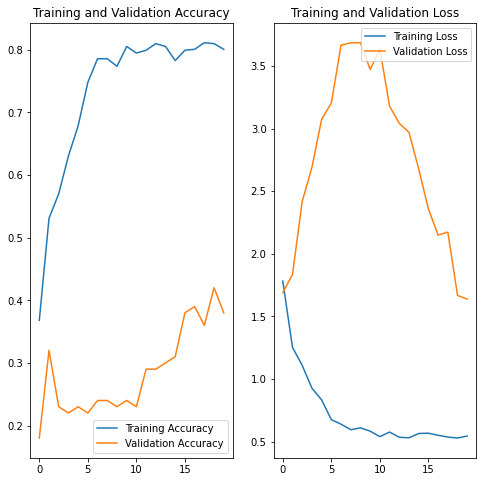

In [ ]:
plt.figure(figsize = (10,10))

plt.figure(figsize = (10,10))

acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


Insights:
- Training Progress: The model's training accuracy steadily improves from 37.25% to 81.15%, while the validation accuracy stagnates around 40%, indicating potential overfitting or poor generalization.

- Learning Rate Adjustment: The learning rate decreases multiple times during training due to the ReduceLROnPlateau callback, from 0.01 to 0.000016, helping refine the model but also signaling potential plateauing.

- Validation Loss: The validation loss fluctuates, with no significant improvement despite reducing the learning rate, which suggests that the model is struggling to generalize well to unseen data.

Next steps:
Try with more frames per sequence.

In [43]:
batch_size = 32
height=width = 80
img_index = [0,1,3,5,6,7,9,10,11,13,15,16,17,19,20,21,23,25,16,27,29]

model = Sequential()
model.add(Conv3D(32, (3, 3, 3), padding='same',
         input_shape=(len(img_index),height,width,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(64, (2, 2, 2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(128, (2, 2, 2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(64,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(5,activation='softmax'))

In [44]:

train_generator = generator(train_path, train_doc, batch_size, img_index, height,width)
val_generator = generator(val_path, val_doc, batch_size,img_index, height,width)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

optimiser = 'sgd'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_21 (Conv3D)          (None, 21, 80, 80, 32)    2624      
                                                                 
 activation_21 (Activation)  (None, 21, 80, 80, 32)    0         
                                                                 
 batch_normalization_35 (Bat  (None, 21, 80, 80, 32)   128       
 chNormalization)                                                
                                                                 
 max_pooling3d_21 (MaxPoolin  (None, 10, 40, 40, 32)   0         
 g3D)                                                            
                                                                 
 conv3d_22 (Conv3D)          (None, 10, 40, 40, 64)    16448     
                                                                 
 activation_22 (Activation)  (None, 10, 40, 40, 64)   

In [45]:
steps_per_epoch=0
validation_steps=0
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [46]:
history2 = model.fit(
    train_generator, 
    steps_per_epoch=steps_per_epoch, 
    epochs=num_epochs, 
    verbose=1, 
    callbacks=callbacks_list, 
    validation_data=val_generator, 
    validation_steps=validation_steps, 
    class_weight=None, 
    workers=1, 
    initial_epoch=0
)

Source path = /home/datasets/Project_data/train ; batch size = 32
Epoch 1/20
21/21 [==============================] - ETA: 0s - loss: 1.6772 - categorical_accuracy: 0.3831Source path = /home/datasets/Project_data/val ; batch size = 32

Epoch 00001: saving model to model_init_2025-01-2715_20_56.169054/model-00001-1.67719-0.38311-1.56590-0.31000.h5
21/21 [==============================] - 112s 6s/step - loss: 1.6772 - categorical_accuracy: 0.3831 - val_loss: 1.5659 - val_categorical_accuracy: 0.3100 - lr: 0.0100
Epoch 2/20
21/21 [==============================] - ETA: 0s - loss: 1.1914 - categorical_accuracy: 0.5475
Epoch 00002: saving model to model_init_2025-01-2715_20_56.169054/model-00002-1.19141-0.54751-2.19078-0.18000.h5
21/21 [==============================] - 111s 6s/step - loss: 1.1914 - categorical_accuracy: 0.5475 - val_loss: 2.1908 - val_categorical_accuracy: 0.1800 - lr: 0.0100
Epoch 3/20
21/21 [==============================] - ETA: 0s - loss: 0.8969 - categorical_accuracy:

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

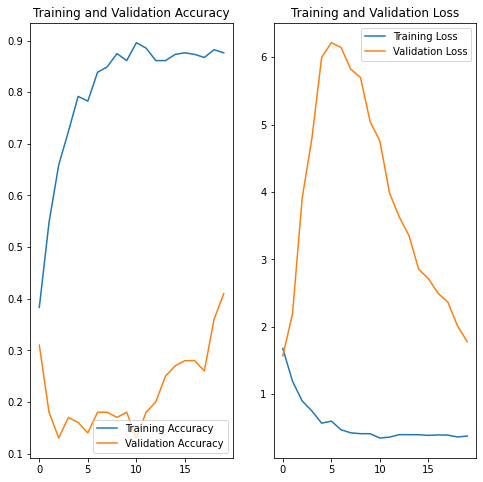

In [47]:
plt.figure(figsize = (10,10))

plt.figure(figsize = (10,10))

acc = history2.history['categorical_accuracy']
val_acc = history2.history['val_categorical_accuracy']

loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Model 3: Image size 120*120

In [32]:
batch_size = 32
height=width = 120
img_index = [0,1,3,5,6,7,9,10,11,13,15,16,17,19,20,21,23,25,16,27,29]

model = Sequential()
model.add(Conv3D(32, (3, 3, 3), padding='same',
         input_shape=(len(img_index),height,width,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(64, (2, 2, 2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(128, (2, 2, 2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(64,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(5,activation='softmax'))

In [39]:
train_generator = generator(train_path, train_doc, batch_size, img_index, height,width)
val_generator = generator(val_path, val_doc, batch_size,img_index, height,width)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

optimiser = 'sgd'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_18 (Conv3D)          (None, 21, 120, 120, 32)  2624      
                                                                 
 activation_18 (Activation)  (None, 21, 120, 120, 32)  0         
                                                                 
 batch_normalization_30 (Bat  (None, 21, 120, 120, 32)  128      
 chNormalization)                                                
                                                                 
 max_pooling3d_18 (MaxPoolin  (None, 10, 60, 60, 32)   0         
 g3D)                                                            
                                                                 
 conv3d_19 (Conv3D)          (None, 10, 60, 60, 64)    16448     
                                                                 
 activation_19 (Activation)  (None, 10, 60, 60, 64)   

In [40]:
steps_per_epoch=0
validation_steps=0
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [41]:
history3 = model.fit(
    train_generator, 
    steps_per_epoch=steps_per_epoch, 
    epochs=num_epochs, 
    verbose=1, 
    callbacks=callbacks_list, 
    validation_data=val_generator, 
    validation_steps=validation_steps, 
    class_weight=None, 
    workers=1, 
    initial_epoch=0
)

Source path = /home/datasets/Project_data/train ; batch size = 32
Epoch 1/20
21/21 [==============================] - ETA: 0s - loss: 1.0475 - categorical_accuracy: 0.5913Source path = /home/datasets/Project_data/val ; batch size = 32

Epoch 00001: saving model to model_init_2025-01-2715_20_56.169054/model-00001-1.04747-0.59125-5.15491-0.16000.h5
21/21 [==============================] - 112s 6s/step - loss: 1.0475 - categorical_accuracy: 0.5913 - val_loss: 5.1549 - val_categorical_accuracy: 0.1600 - lr: 0.0100
Epoch 2/20
21/21 [==============================] - ETA: 0s - loss: 0.8132 - categorical_accuracy: 0.6682
Epoch 00002: saving model to model_init_2025-01-2715_20_56.169054/model-00002-0.81321-0.66817-6.32288-0.16000.h5
21/21 [==============================] - 110s 5s/step - loss: 0.8132 - categorical_accuracy: 0.6682 - val_loss: 6.3229 - val_categorical_accuracy: 0.1600 - lr: 0.0100
Epoch 3/20
21/21 [==============================] - ETA: 0s - loss: 0.7599 - categorical_accuracy:

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

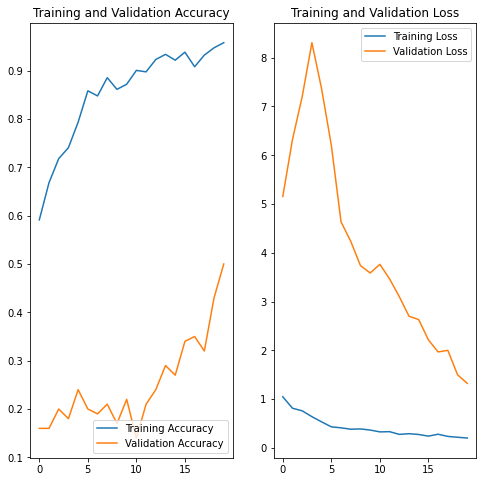

In [42]:
plt.figure(figsize = (10,10))

plt.figure(figsize = (10,10))

acc = history3.history['categorical_accuracy']
val_acc = history3.history['val_categorical_accuracy']

loss = history3.history['loss']
val_loss = history3.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
## Model 4: Parameter tuning

In [54]:
from keras.models import Sequential
from keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, Dropout, BatchNormalization, Activation
from keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

model = Sequential()

# First Convolution Block
model.add(Conv3D(32, (3, 3, 3), padding='same', input_shape=(len(img_index), height, width, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# Second Convolution Block
model.add(Conv3D(64, (3, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# Third Convolution Block
model.add(Conv3D(128, (3, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# Flatten and Dense Layers
model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Output Layer
model.add(Dense(5, activation='softmax'))


train_generator = generator(train_path, train_doc, batch_size, img_index, height,width)
val_generator = generator(val_path, val_doc, batch_size,img_index, height,width)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, verbose=1, patience=3, min_lr=1e-6)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

optimiser = 'sgd'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_27 (Conv3D)          (None, 21, 80, 80, 32)    2624      
                                                                 
 activation_27 (Activation)  (None, 21, 80, 80, 32)    0         
                                                                 
 batch_normalization_46 (Bat  (None, 21, 80, 80, 32)   128       
 chNormalization)                                                
                                                                 
 max_pooling3d_27 (MaxPoolin  (None, 10, 40, 40, 32)   0         
 g3D)                                                            
                                                                 
 conv3d_28 (Conv3D)          (None, 10, 40, 40, 64)    55360     
                                                                 
 activation_28 (Activation)  (None, 10, 40, 40, 64)   

In [55]:
steps_per_epoch=0
validation_steps=0
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [56]:
history3 = model.fit(
    train_generator, 
    steps_per_epoch=steps_per_epoch, 
    epochs=num_epochs, 
    verbose=1, 
    callbacks=callbacks_list, 
    validation_data=val_generator, 
    validation_steps=validation_steps, 
    class_weight=None, 
    workers=1, 
    initial_epoch=0
)

Source path = /home/datasets/Project_data/train ; batch size = 32
Epoch 1/20
21/21 [==============================] - ETA: 0s - loss: 2.7752 - categorical_accuracy: 0.2790Source path = /home/datasets/Project_data/val ; batch size = 32

Epoch 00001: saving model to model_init_2025-01-2715_20_56.169054/model-00001-2.77519-0.27903-2.86731-0.23000.h5
21/21 [==============================] - 113s 6s/step - loss: 2.7752 - categorical_accuracy: 0.2790 - val_loss: 2.8673 - val_categorical_accuracy: 0.2300 - lr: 0.0100
Epoch 2/20
21/21 [==============================] - ETA: 0s - loss: 2.3219 - categorical_accuracy: 0.3906
Epoch 00002: saving model to model_init_2025-01-2715_20_56.169054/model-00002-2.32189-0.39065-2.36127-0.28000.h5
21/21 [==============================] - 109s 5s/step - loss: 2.3219 - categorical_accuracy: 0.3906 - val_loss: 2.3613 - val_categorical_accuracy: 0.2800 - lr: 0.0100
Epoch 3/20
21/21 [==============================] - ETA: 0s - loss: 2.1796 - categorical_accuracy:

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

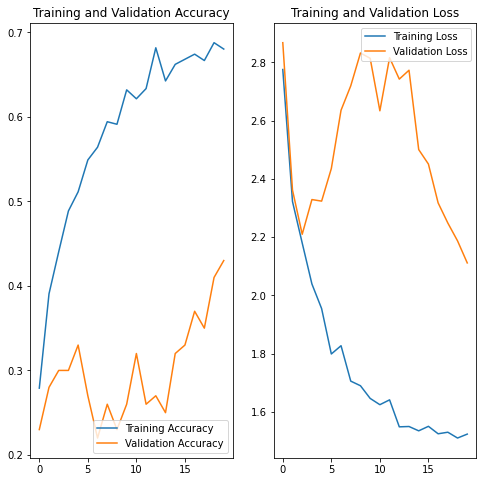

In [57]:
plot_model_performace(history3, num_epochs)

## Model 5: Increase number of frames to 30 and reduce size to 84

In [27]:
from keras.models import Sequential
from keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, Dropout, BatchNormalization, Activation
from keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

batch_size = 32
height=width = 84
img_index = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29]

model = Sequential()

# First Convolution Block
model.add(Conv3D(32, (3, 3, 3), padding='same', input_shape=(len(img_index), height, width, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# Second Convolution Block
model.add(Conv3D(64, (3, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# Third Convolution Block
model.add(Conv3D(128, (3, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# Flatten and Dense Layers
model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Output Layer
model.add(Dense(5, activation='softmax'))


train_generator = generator(train_path, train_doc, batch_size, img_index, height,width)
val_generator = generator(val_path, val_doc, batch_size,img_index, height,width)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, verbose=1, patience=3, min_lr=1e-6)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

optimiser = 'sgd'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())


In [9]:
steps_per_epoch=0
validation_steps=0
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [10]:
history4 = model.fit(
    train_generator, 
    steps_per_epoch=steps_per_epoch, 
    epochs=num_epochs, 
    verbose=1, 
    callbacks=callbacks_list, 
    validation_data=val_generator, 
    validation_steps=validation_steps, 
    class_weight=None, 
    workers=1, 
    initial_epoch=0
)

Source path = /home/datasets/Project_data/train ; batch size = 32
Epoch 1/20


2025-01-28 04:59:28.726828: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302
2025-01-28 04:59:31.111737: I tensorflow/stream_executor/cuda/cuda_blas.cc:1792] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


21/21 [==============================] - ETA: 0s - loss: 2.7059 - categorical_accuracy: 0.2821Source path = /home/datasets/Project_data/val ; batch size = 32

Epoch 00001: saving model to model_init_2025-01-2804_58_52.360592/model-00001-2.70588-0.28205-2.42295-0.19000.h5
21/21 [==============================] - 193s 9s/step - loss: 2.7059 - categorical_accuracy: 0.2821 - val_loss: 2.4230 - val_categorical_accuracy: 0.1900 - lr: 0.0100
Epoch 2/20
21/21 [==============================] - ETA: 0s - loss: 2.3500 - categorical_accuracy: 0.3741
Epoch 00002: saving model to model_init_2025-01-2804_58_52.360592/model-00002-2.35004-0.37406-2.36938-0.24000.h5
21/21 [==============================] - 169s 8s/step - loss: 2.3500 - categorical_accuracy: 0.3741 - val_loss: 2.3694 - val_categorical_accuracy: 0.2400 - lr: 0.0100
Epoch 3/20
21/21 [==============================] - ETA: 0s - loss: 2.1286 - categorical_accuracy: 0.4359
Epoch 00003: saving model to model_init_2025-01-2804_58_52.360592/mod

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

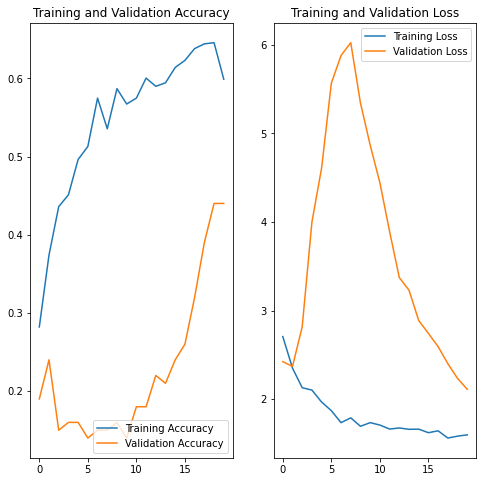

In [11]:
plot_model_performace(history4, num_epochs)

## Model 6: Increase batch size and number of epochs

In [18]:
from keras.models import Sequential
from keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, Dropout, BatchNormalization, Activation
from keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

batch_size = 64
height=width = 84
img_index = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29]

model = Sequential()

# First Convolution Block
model.add(Conv3D(32, (3, 3, 3), padding='same', input_shape=(len(img_index), height, width, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# Second Convolution Block
model.add(Conv3D(64, (3, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# Third Convolution Block
model.add(Conv3D(128, (3, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# Flatten and Dense Layers
model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Output Layer
model.add(Dense(5, activation='softmax'))


train_generator = generator(train_path, train_doc, batch_size, img_index, height,width)
val_generator = generator(val_path, val_doc, batch_size,img_index, height,width)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, verbose=1, patience=3, min_lr=1e-6)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

optimiser = 'sgd'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())
steps_per_epoch=0
validation_steps=0
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_3 (Conv3D)           (None, 30, 84, 84, 32)    2624      
                                                                 
 activation_3 (Activation)   (None, 30, 84, 84, 32)    0         
                                                                 
 batch_normalization_11 (Bat  (None, 30, 84, 84, 32)   128       
 chNormalization)                                                
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 15, 42, 42, 32)   0         
 3D)                                                             
                                                                 
 conv3d_4 (Conv3D)           (None, 15, 42, 42, 64)    55360     
                                                                 
 activation_4 (Activation)   (None, 15, 42, 42, 64)   

In [35]:
num_epochs =30
history5 = model.fit(
    train_generator, 
    steps_per_epoch=steps_per_epoch, 
    epochs=num_epochs, 
    verbose=1, 
    callbacks=callbacks_list, 
    validation_data=val_generator, 
    validation_steps=validation_steps, 
    class_weight=None, 
    workers=1, 
    initial_epoch=0
)

Source path = /home/datasets/Project_data/train ; batch size = 64
Epoch 1/30
11/11 [==============================] - ETA: 0s - loss: 2.6977 - categorical_accuracy: 0.3032 Source path = /home/datasets/Project_data/val ; batch size = 64

Epoch 00001: saving model to model_init_2025-01-2804_58_52.360592/model-00001-2.69767-0.30317-2.22694-0.25000.h5
11/11 [==============================] - 160s 16s/step - loss: 2.6977 - categorical_accuracy: 0.3032 - val_loss: 2.2269 - val_categorical_accuracy: 0.2500 - lr: 0.0100
Epoch 2/30
11/11 [==============================] - ETA: 0s - loss: 2.3799 - categorical_accuracy: 0.3499 
Epoch 00002: saving model to model_init_2025-01-2804_58_52.360592/model-00002-2.37988-0.34992-2.38162-0.14000.h5
11/11 [==============================] - 153s 15s/step - loss: 2.3799 - categorical_accuracy: 0.3499 - val_loss: 2.3816 - val_categorical_accuracy: 0.1400 - lr: 0.0100
Epoch 3/30
11/11 [==============================] - ETA: 0s - loss: 2.1016 - categorical_accur

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

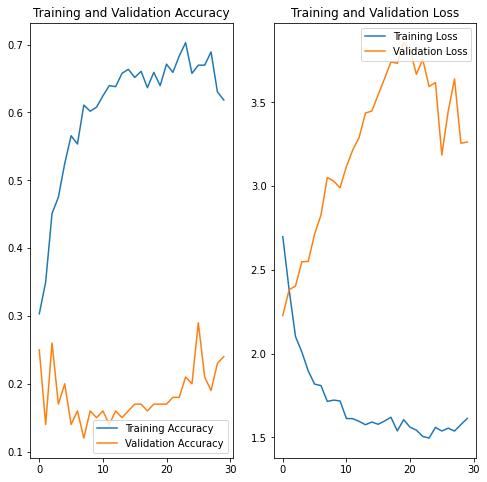

In [37]:
plot_model_performace(history5, num_epochs)

## Model 7: CNN + LSTM model

In [21]:
from keras.layers.recurrent import LSTM
batch_size = 32
height=width = 84
img_index = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29]

#write your model here
model = Sequential()
model.add(Conv3D(32, (3, 3, 3), padding='same',
         input_shape=(len(img_index), height, width,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(64, (2, 2, 2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(128, (2, 2, 2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(TimeDistributed(Flatten()))
model.add(LSTM(128))
model.add(Dropout(0.5))

model.add(Dense(64,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(5,activation='softmax'))

In [29]:
train_generator = generator(train_path, train_doc, batch_size, img_index, height,width)
val_generator = generator(val_path, val_doc, batch_size,img_index, height,width)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, verbose=1, patience=3, min_lr=1e-6)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

optimiser = 'sgd'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_15 (Conv3D)          (None, 30, 84, 84, 32)    2624      
                                                                 
 activation_15 (Activation)  (None, 30, 84, 84, 32)    0         
                                                                 
 batch_normalization_57 (Bat  (None, 30, 84, 84, 32)   128       
 chNormalization)                                                
                                                                 
 max_pooling3d_15 (MaxPoolin  (None, 15, 42, 42, 32)   0         
 g3D)                                                            
                                                                 
 conv3d_16 (Conv3D)          (None, 15, 42, 42, 64)    16448     
                                                                 
 activation_16 (Activation)  (None, 15, 42, 42, 64)  

In [32]:
steps_per_epoch=0
validation_steps=0
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [33]:
num_epochs=20
history6 = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/tmp/ipykernel_233/1118932202.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history6 = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Source path = /home/datasets/Project_data/train ; batch size = 32
Epoch 1/20
21/21 [==============================] - ETA: 0s - loss: 1.9296 - categorical_accuracy: 0.3002Source path = /home/datasets/Project_data/val ; batch size = 32

Epoch 00001: saving model to model_init_2025-01-2804_58_52.360592/model-00001-1.92958-0.30015-1.57655-0.21000.h5
21/21 [==============================] - 166s 8s/step - loss: 1.9296 - categorical_accuracy: 0.3002 - val_loss: 1.5766 - val_categorical_accuracy: 0.2100 - lr: 0.0100
Epoch 2/20
21/21 [==============================] - ETA: 0s - loss: 1.6287 - categorical_accuracy: 0.3695
Epoch 00002: saving model to model_init_2025-01-2804_58_52.360592/model-00002-1.62867-0.36953-1.52414-0.31000.h5
21/21 [==============================] - 159s 8s/step - loss: 1.6287 - categorical_accuracy: 0.3695 - val_loss: 1.5241 - val_categorical_accuracy: 0.3100 - lr: 0.0100
Epoch 3/20
21/21 [==============================] - ETA: 0s - loss: 1.4600 - categorical_accuracy:

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

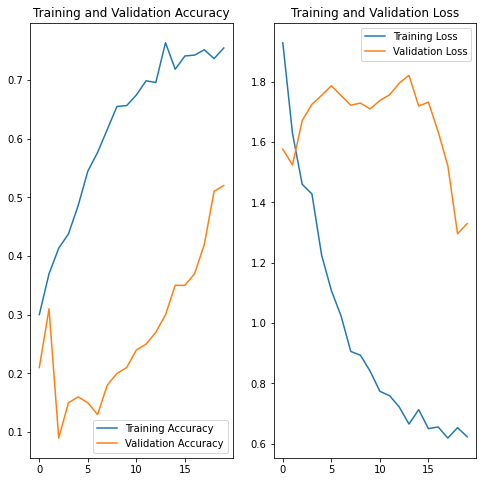

In [39]:
num_epochs =20
plot_model_performace(history6, num_epochs)

## Model 8: LSTM + GRU

In [19]:
from keras.models import Sequential
from keras.layers import TimeDistributed, Conv2D, BatchNormalization, MaxPooling2D, Flatten, GRU, Dropout, Dense
from tensorflow.keras.optimizers import Adam

batch_size = 32
height = width = 120
img_index = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]

# Assuming RGB images (3 channels)
input_shape = (len(img_index), height, width, 3)  # (time_steps, height, width, channels)

GRU_lstm = Sequential()

# Conv2D layer wrapped with TimeDistributed
GRU_lstm.add(TimeDistributed(Conv2D(16, (3, 3), padding='same', activation='relu'), input_shape=input_shape))
GRU_lstm.add(TimeDistributed(BatchNormalization()))
GRU_lstm.add(TimeDistributed(MaxPooling2D((2, 2))))

GRU_lstm.add(TimeDistributed(Conv2D(32, (3, 3), padding='same', activation='relu')))
GRU_lstm.add(TimeDistributed(BatchNormalization()))
GRU_lstm.add(TimeDistributed(MaxPooling2D((2, 2))))

GRU_lstm.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', activation='relu')))
GRU_lstm.add(TimeDistributed(BatchNormalization()))
GRU_lstm.add(TimeDistributed(MaxPooling2D((2, 2))))

GRU_lstm.add(TimeDistributed(Conv2D(128, (3, 3), padding='same', activation='relu')))
GRU_lstm.add(TimeDistributed(BatchNormalization()))
GRU_lstm.add(TimeDistributed(MaxPooling2D((2, 2))))

# Flattening the output of the last Conv2D layer
GRU_lstm.add(TimeDistributed(Flatten()))

# GRU Layer
GRU_lstm.add(GRU(128))
GRU_lstm.add(Dropout(0.25))

# Dense Layer
GRU_lstm.add(Dense(128, activation='relu'))
GRU_lstm.add(Dropout(0.25))

# Output Layer (5 classes)
GRU_lstm.add(Dense(5, activation='softmax'))

# Compile the model
optimiser = 'Adam'
GRU_lstm.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Print the model summary
GRU_lstm.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_17 (TimeDi  (None, 30, 120, 120, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_18 (TimeDi  (None, 30, 120, 120, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_19 (TimeDi  (None, 30, 60, 60, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_20 (TimeDi  (None, 30, 60, 60, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_21 (TimeDi  (None, 30, 60, 60, 32)  

In [17]:
train_generator = generator(train_path, train_doc, batch_size, img_index, height,width)
val_generator = generator(val_path, val_doc, batch_size,img_index, height,width)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, verbose=1, patience=3, min_lr=1e-6)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

optimiser = 'Adam'
GRU_lstm.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (GRU_lstm.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_39 (TimeDi  (None, 30, 120, 120, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_40 (TimeDi  (None, 30, 120, 120, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_41 (TimeDi  (None, 30, 60, 60, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_42 (TimeDi  (None, 30, 60, 60, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_43 (TimeDi  (None, 30, 60, 60, 32)  

In [18]:
steps_per_epoch=0
validation_steps=0
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [14]:
num_epochs=20
history7 = GRU_lstm.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path = /home/datasets/Project_data/train ; batch size = 32
Epoch 1/20


2025-01-28 08:50:43.934935: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


21/21 [==============================] - ETA: 0s - loss: 1.4924 - categorical_accuracy: 0.3861Source path = /home/datasets/Project_data/val ; batch size = 32

Epoch 00001: saving model to model_init_2025-01-2808_49_53.614482/model-00001-1.49242-0.38612-1.56253-0.22000.h5
21/21 [==============================] - 166s 8s/step - loss: 1.4924 - categorical_accuracy: 0.3861 - val_loss: 1.5625 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 2/20
21/21 [==============================] - ETA: 0s - loss: 1.0383 - categorical_accuracy: 0.6109
Epoch 00002: saving model to model_init_2025-01-2808_49_53.614482/model-00002-1.03829-0.61086-2.10036-0.17000.h5
21/21 [==============================] - 161s 8s/step - loss: 1.0383 - categorical_accuracy: 0.6109 - val_loss: 2.1004 - val_categorical_accuracy: 0.1700 - lr: 0.0010
Epoch 3/20
21/21 [==============================] - ETA: 0s - loss: 0.8083 - categorical_accuracy: 0.6742
Epoch 00003: saving model to model_init_2025-01-2808_49_53.614482/mod

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

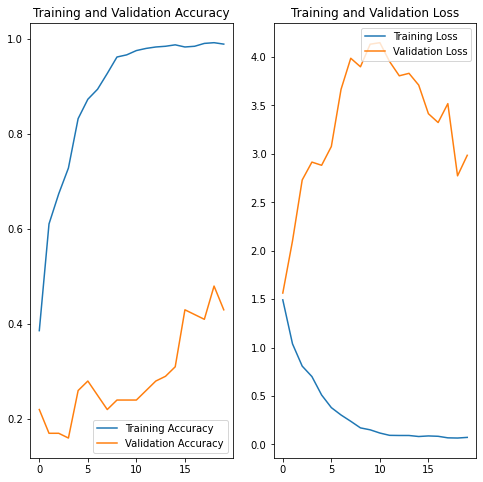

In [15]:
plot_model_performace(history7, num_epochs)

In [34]:
import random
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img

def augment_image(image):
    """ Apply random augmentations to a given image """
    # Random rotation
    if random.random() > 0.5:
        angle = random.randint(-40, 40)  # Random angle between -40 to 40 degrees
        image = array_to_img(image).rotate(angle)
        image = img_to_array(image)
    
    # Random flip
    if random.random() > 0.5:
        image = np.fliplr(image)  # Flip horizontally

    # Random zoom (using a simple zoom effect)
    if random.random() > 0.5:
        zoom_factor = random.uniform(0.8, 1.2)  # Random zoom between 80% and 120%
        image = np.array(array_to_img(image).resize(
            (int(image.shape[1] * zoom_factor), int(image.shape[0] * zoom_factor))))
        image = img_to_array(image)
    
    # Random shift
    if random.random() > 0.5:
        tx = random.uniform(-0.2, 0.2)  # Random shift along the x-axis
        ty = random.uniform(-0.2, 0.2)  # Random shift along the y-axis
        image = np.roll(image, int(tx * image.shape[0]), axis=0)
        image = np.roll(image, int(ty * image.shape[1]), axis=1)

    # Normalize image
    image = image / 255.0  # Normalize to [0, 1]
    return image

from skimage.transform import resize
from imageio import imread
import numpy as np
import os

def generator_with_augmentation(source_path, folder_list, batch_size, img_index, height, width):
    print('Source path =', source_path, '; batch size =', batch_size)
    
    while True:
        t = np.random.permutation(folder_list)  # Shuffle folder list
        num_batches = len(t) // batch_size
        
        for batch in range(num_batches):  # Iterate over number of batches
            batch_data = np.zeros((batch_size, len(img_index), height, width, 3))  # (batch_size, num_images, height, width, channels)
            batch_labels = np.zeros((batch_size, 5))  # One-hot encoding for labels
            
            for folder in range(batch_size):  # Iterate over batch size
                folder_path = os.path.join(source_path, t[folder + (batch * batch_size)].split(';')[0])
                imgs = os.listdir(folder_path)  # List all images in the folder
                
                for idx, item in enumerate(img_index):  # Iterate over selected frame indices
                    image_path = os.path.join(folder_path, imgs[item])
                    image = imread(image_path).astype(np.float32)
                    
                    # Resize the image to (height, width)
                    image = resize(image, (height, width), mode='reflect').astype(np.float32)

                    # Normalize and add to batch
                    batch_data[folder, idx, :, :, 0] = image[:, :, 0]  # Red channel
                    batch_data[folder, idx, :, :, 1] = image[:, :, 1]  # Green channel
                    batch_data[folder, idx, :, :, 2] = image[:, :, 2]  # Blue channel
                
                # Assign label to the batch (one-hot encoding)
                label_idx = int(t[folder + (batch * batch_size)].split(';')[2])
                batch_labels[folder, label_idx] = 1

            yield batch_data, batch_labels  # Yield the batch data and labels
        
        # Handle remaining batch if data size isn't perfectly divisible by batch_size
        if len(t) % batch_size != 0:
            remaining_batch_size = len(t) % batch_size
            batch_data = np.zeros((remaining_batch_size, len(img_index), height, width, 3))  # Adjust for remaining batch size
            batch_labels = np.zeros((remaining_batch_size, 5))
            
            for folder in range(remaining_batch_size):  # Iterate over remaining batch size
                folder_path = os.path.join(source_path, t[folder + (num_batches * batch_size)].split(';')[0])
                imgs = os.listdir(folder_path)
                
                for idx, item in enumerate(img_index):  # Iterate over selected frame indices
                    image_path = os.path.join(folder_path, imgs[item])
                    image = imread(image_path).astype(np.float32)
                    
                    # Resize the image to (height, width)
                    image = resize(image, (height, width), mode='reflect').astype(np.float32)

                    # Normalize and add to batch
                    batch_data[folder, idx, :, :, 0] = image[:, :, 0]  # Red channel
                    batch_data[folder, idx, :, :, 1] = image[:, :, 1]  # Green channel
                    batch_data[folder, idx, :, :, 2] = image[:, :, 2]  # Blue channel

                # Assign label to the batch (one-hot encoding)
                label_idx = int(t[folder + (num_batches * batch_size)].split(';')[2])
                batch_labels[folder, label_idx] = 1

            yield batch_data, batch_labels  # Yield the remaining batch


In [9]:
from keras.models import Sequential
from keras.layers import TimeDistributed, Conv2D, BatchNormalization, MaxPooling2D, Flatten, GRU, Dropout, Dense
from tensorflow.keras.optimizers import Adam

batch_size = 32
height = width = 120
img_index = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]

# Assuming RGB images (3 channels)
input_shape = (len(img_index), height, width, 3)  # (time_steps, height, width, channels)

GRU_lstm = Sequential()

# Conv2D layer wrapped with TimeDistributed
GRU_lstm.add(TimeDistributed(Conv2D(16, (3, 3), padding='same', activation='relu'), input_shape=input_shape))
GRU_lstm.add(TimeDistributed(BatchNormalization()))
GRU_lstm.add(TimeDistributed(MaxPooling2D((2, 2))))

GRU_lstm.add(TimeDistributed(Conv2D(32, (3, 3), padding='same', activation='relu')))
GRU_lstm.add(TimeDistributed(BatchNormalization()))
GRU_lstm.add(TimeDistributed(MaxPooling2D((2, 2))))

GRU_lstm.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', activation='relu')))
GRU_lstm.add(TimeDistributed(BatchNormalization()))
GRU_lstm.add(TimeDistributed(MaxPooling2D((2, 2))))

GRU_lstm.add(TimeDistributed(Conv2D(128, (3, 3), padding='same', activation='relu')))
GRU_lstm.add(TimeDistributed(BatchNormalization()))
GRU_lstm.add(TimeDistributed(MaxPooling2D((2, 2))))

# Flattening the output of the last Conv2D layer
GRU_lstm.add(TimeDistributed(Flatten()))

# GRU Layer
GRU_lstm.add(GRU(128))
GRU_lstm.add(Dropout(0.25))

# Dense Layer
GRU_lstm.add(Dense(128, activation='relu'))
GRU_lstm.add(Dropout(0.25))

# Output Layer (5 classes)
GRU_lstm.add(Dense(5, activation='softmax'))



In [36]:
train_generator = generator_with_augmentation(train_path, train_doc, batch_size, img_index, height,width)
val_generator = generator(val_path, val_doc, batch_size,img_index, height,width)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, verbose=1, patience=3, min_lr=1e-6)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

optimiser = 'Adam'
GRU_lstm.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (GRU_lstm.summary())

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_91 (TimeDi  (None, 30, 120, 120, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_92 (TimeDi  (None, 30, 120, 120, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_93 (TimeDi  (None, 30, 60, 60, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_94 (TimeDi  (None, 30, 60, 60, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_95 (TimeDi  (None, 30, 60, 60, 32)  

In [37]:
steps_per_epoch=0
validation_steps=0
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [38]:
num_epochs=20
history8 = GRU_lstm.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path = /home/datasets/Project_data/train ; batch size = 32
Epoch 1/20
21/21 [==============================] - ETA: 0s - loss: 1.2614 - categorical_accuracy: 0.4600Source path = /home/datasets/Project_data/val ; batch size = 32

Epoch 00001: saving model to model_init_2025-01-2808_49_53.614482/model-00001-1.26139-0.46003-2.35886-0.16000.h5
21/21 [==============================] - 160s 8s/step - loss: 1.2614 - categorical_accuracy: 0.4600 - val_loss: 2.3589 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/20
21/21 [==============================] - ETA: 0s - loss: 0.9340 - categorical_accuracy: 0.5882
Epoch 00002: saving model to model_init_2025-01-2808_49_53.614482/model-00002-0.93404-0.58824-2.92003-0.15000.h5
21/21 [==============================] - 156s 8s/step - loss: 0.9340 - categorical_accuracy: 0.5882 - val_loss: 2.9200 - val_categorical_accuracy: 0.1500 - lr: 0.0010
Epoch 3/20
21/21 [==============================] - ETA: 0s - loss: 0.7929 - categorical_accuracy:

In [6]:
plot_model_performace(history8, num_epochs)

NameError: name 'history8' is not defined

## Model: With transfer learning

In [7]:
# Importing the transfer learning model:
from keras.applications import mobilenet

mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

2025-01-28 12:07:39.156003: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2025-01-28 12:07:39.156068: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14800 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1e:00.0, compute capability: 7.5


17235968/17225924 [==============================] - 2s 0us/step


In [22]:
input_shape = (18,120,120,3)
        
mobileNetModel= Sequential()
mobileNetModel.add(TimeDistributed(mobilenet_transfer,input_shape=(input_shape)))


for layer in mobileNetModel.layers:
    layer.trainable = False


mobileNetModel.add(TimeDistributed(BatchNormalization()))
mobileNetModel.add(TimeDistributed(MaxPooling2D((2, 2))))
mobileNetModel.add(TimeDistributed(Flatten()))

mobileNetModel.add(LSTM(128))
mobileNetModel.add(Dropout(0.25))

mobileNetModel.add(Dense(128,activation='relu'))
mobileNetModel.add(Dropout(0.25))

mobileNetModel.add(Dense(5, activation='softmax'))


optimiser = optimizers.Adam()
mobileNetModel.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (mobileNetModel.summary())

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_35 (TimeDi  (None, 18, 3, 3, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_36 (TimeDi  (None, 18, 3, 3, 1024)   4096      
 stributed)                                                      
                                                                 
 time_distributed_37 (TimeDi  (None, 18, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_38 (TimeDi  (None, 18, 1024)         0         
 stributed)                                                      
                                                                 
 lstm_1 (LSTM)               (None, 128)              

In [23]:
print("Total Params in model:", mobileNetModel.count_params())

Total Params in model: 3840453


In [27]:
import cv2
import imageio as imio
from PIL import Image

def generatorMobileNet(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    
    #create a list of image numbers you want to use for a particular video
    img_idx = [1,2,4,6,7,8,10,12,14,16,18,20,21,22,24,26,27,29]
    #list(range(0,29,2))
    
    while True:
        t = np.random.permutation(folder_list)
        
# calculate the number of batches
        num_batches = int(len(t)/batch_size)
        
# we iterate over the number of batches
        for batch in range(num_batches): 
            
# x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB          
            batch_data = np.zeros((batch_size,18,120,120,3))
# batch_labels is the one hot representation of the output
            batch_labels = np.zeros((batch_size,5))

# iterate over the batch_size    
            for folder in range(batch_size): 
# read all the images in the folder        
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
#  Iterate over the frames/images of a folder to read them in    
                for idx,item in enumerate(img_idx):
                    image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item],cv2.IMREAD_UNCHANGED).astype(np.float32)
                    
#crop the images and resize them. Note that the images are of 2 different shape 
#and the conv3D will throw error if the inputs in a batch have different shapes
                    if image.shape[1] == 160:
                        image = cv2.resize(image[:,20:140,:],(120,120),interpolation = cv2.INTER_AREA).astype(np.float32)
                    else:
                        image = cv2.resize(image,(120,120),interpolation = cv2.INTER_AREA).astype(np.float32)
                                
#normalise and feed in the image

                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
#you yield the batch_data and the batch_labels, remember what does yield do                
            yield batch_data, batch_labels 

        
# write the code for the remaining data points which are left after full batches
        if (len(t)%batch_size) != 0:
            batch_data = np.zeros((len(t)%batch_size,18,120,120,3))
            batch_labels = np.zeros((len(t)%batch_size,5))
            for folder in range(len(t)%batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = cv2.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item],cv2.IMREAD_UNCHANGED).astype(np.float32)
                    if image.shape[1] == 160:
                        image = cv2.resize(image[:,20:140,:],(120,120),interpolation = cv2.INTER_AREA).astype(np.float32)
                    else:
                        image = cv2.resize(image,(120,120),interpolation = cv2.INTER_AREA).astype(np.float32)

                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255

                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels

In [28]:
train_generator = generatorMobileNet(train_path, train_doc, batch_size)
val_generator = generatorMobileNet(val_path, val_doc, batch_size)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

# write the REducelronplateau code here
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4)

callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [29]:
history9 = mobileNetModel.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/tmp/ipykernel_233/3971067953.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history9 = mobileNetModel.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Source path =  /home/datasets/Project_data/train ; batch size = 32
Epoch 1/20


2025-01-28 12:13:29.115323: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


21/21 [==============================] - ETA: 0s - loss: 1.5363 - categorical_accuracy: 0.3107Source path =  /home/datasets/Project_data/val ; batch size = 32

Epoch 00001: saving model to model_init_2025-01-2812_09_03.372721/model-00001-1.53629-0.31071-1.31865-0.54000.h5
21/21 [==============================] - 37s 2s/step - loss: 1.5363 - categorical_accuracy: 0.3107 - val_loss: 1.3186 - val_categorical_accuracy: 0.5400 - lr: 0.0010
Epoch 2/20
21/21 [==============================] - ETA: 0s - loss: 0.9628 - categorical_accuracy: 0.6938
Epoch 00002: saving model to model_init_2025-01-2812_09_03.372721/model-00002-0.96280-0.69382-0.90935-0.69000.h5
21/21 [==============================] - 31s 2s/step - loss: 0.9628 - categorical_accuracy: 0.6938 - val_loss: 0.9094 - val_categorical_accuracy: 0.6900 - lr: 0.0010
Epoch 3/20
21/21 [==============================] - ETA: 0s - loss: 0.5187 - categorical_accuracy: 0.8431
Epoch 00003: saving model to model_init_2025-01-2812_09_03.372721/mode

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

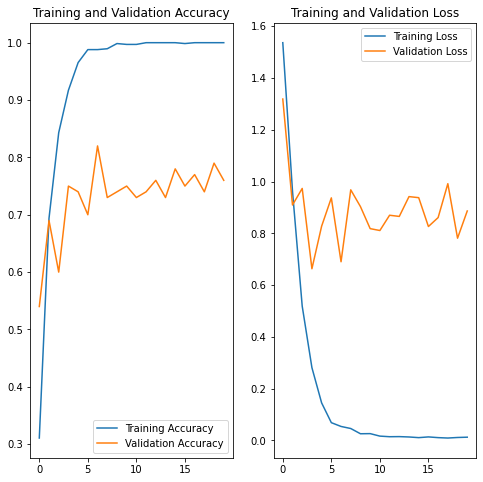

In [30]:
plot_model_performace(history9, num_epochs)

In [31]:
from keras.applications import mobilenet

mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

input_shape = (18,120,120,3)
        
mobileNetModelWeight = Sequential()
mobileNetModelWeight.add(TimeDistributed(mobilenet_transfer,input_shape=(input_shape)))


mobileNetModelWeight.add(TimeDistributed(BatchNormalization()))
mobileNetModelWeight.add(TimeDistributed(MaxPooling2D((2, 2))))
mobileNetModelWeight.add(TimeDistributed(Flatten()))

mobileNetModelWeight.add(GRU(128))
mobileNetModelWeight.add(Dropout(0.25))

mobileNetModelWeight.add(Dense(128,activation='relu'))
mobileNetModelWeight.add(Dropout(0.25))

mobileNetModelWeight.add(Dense(5, activation='softmax'))


optimiser = optimizers.Adam()
mobileNetModelWeight.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (mobileNetModel.summary())

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_35 (TimeDi  (None, 18, 3, 3, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_36 (TimeDi  (None, 18, 3, 3, 1024)   4096      
 stributed)                                                      
                                                                 
 time_distributed_37 (TimeDi  (None, 18, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_38 (TimeDi  (None, 18, 1024)         0         
 stributed)                                                      
                                                                 
 lstm_1 (LSTM)               (None, 128)              

In [32]:
train_generator = generatorMobileNet(train_path, train_doc, batch_size)
val_generator = generatorMobileNet(val_path, val_doc, batch_size)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

# write the REducelronplateau code here
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4)

callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [33]:
history10 = mobileNetModelWeight.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 32


/tmp/ipykernel_233/3747917404.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history10 = mobileNetModelWeight.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Epoch 1/20
21/21 [==============================] - ETA: 0s - loss: 1.1339 - categorical_accuracy: 0.5460Source path =  /home/datasets/Project_data/val ; batch size = 32

Epoch 00001: saving model to model_init_2025-01-2812_09_03.372721/model-00001-1.13395-0.54600-1.25195-0.44000.h5
21/21 [==============================] - 39s 2s/step - loss: 1.1339 - categorical_accuracy: 0.5460 - val_loss: 1.2519 - val_categorical_accuracy: 0.4400 - lr: 0.0010
Epoch 2/20
21/21 [==============================] - ETA: 0s - loss: 0.4039 - categorical_accuracy: 0.8567
Epoch 00002: saving model to model_init_2025-01-2812_09_03.372721/model-00002-0.40387-0.85671-0.73143-0.67000.h5
21/21 [==============================] - 32s 2s/step - loss: 0.4039 - categorical_accuracy: 0.8567 - val_loss: 0.7314 - val_categorical_accuracy: 0.6700 - lr: 0.0010
Epoch 3/20
21/21 [==============================] - ETA: 0s - loss: 0.1365 - categorical_accuracy: 0.9502
Epoch 00003: saving model to model_init_2025-01-2812_09_03.

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

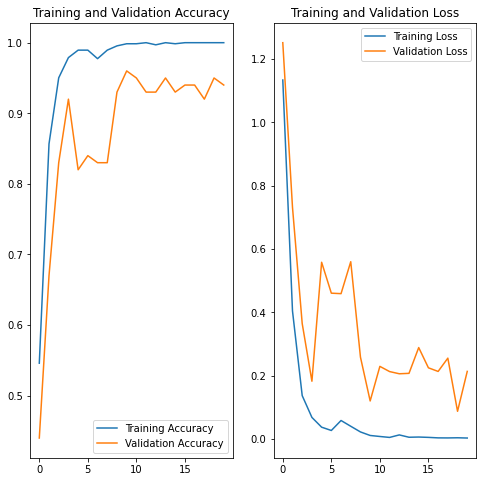

In [34]:
plot_model_performace(history10, num_epochs)